### Coursera Capstone Final Project - Battle of the Neighborhoods<br>
*Teri Nguyen_Shank*

Introduction

The objective of this project is to provide a brief data analysis about Toronto's boroughs and neighborhoods using two data sets, Foursquare API, and Python libraries. We explore and segment the boroughs and neighborhoods to search for trending venues 

Data
1.	List of postal codes of Canada: M from Wikipedia: This is a list of postal codes in Canada that is organized in a form of a table where the first letter is M. 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

2.	Geographical coordinates of each postal code from a csv file are ready to be extracted.
GeoSpatial_Coordinate.CSV

3.	Foursquare API: Foursquare location data
https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit

4.	Toronto information
https://en.wikipedia.org/wiki/Toronto

Methodology
1. Download the dataset using BeautifulSoup and wget command
2. Wrangle, clean, and read data into structural data frames
3. Define get_category_type() and getNearbyVenues() to extract the categories of the venues and the nearby venues.
4. Visualizations maps and grapph using Matplot Library and Folium
5. Get locations' coordinates of using geopy library
6. Utilize Foursquare API for locations' venues and rating


## Part 1. Scrapping the Wikipedia page. Wrangling the data, cleaning, and reading it into a pandas dataframe into a structured format

### Download all the dependencies

In [2]:
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json # library to handle JSON files
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

! pip install folium==0.5.0
import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


### Scrapping the Wikipedia page. Wrangling the data, cleaning, and reading it into a pandas dataframe into a structured format¶

In [3]:
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 

soup = BeautifulSoup(data, 'html5lib')

#creating Toronto Dataframe
df= pd.DataFrame(columns = ['PostalCode','Borough','Neighborhood'])


#scrapping all rows of the table
table_rows = soup.find('table').tbody.find_all('tr')

# filtering rows and inserting data to df_toronto
for rows in table_rows :
    for column in rows.find_all('td') :
        if column.span.text != 'Not assigned' :
            span  = column.span.text.split('(')
            df = df.append({'PostalCode' : column.b.text,
                              'Borough' : span[0],
                              'Neighborhood' : span[1][:-1]}, ignore_index=True)
            
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df = df.sort_values('PostalCode').reset_index(drop = True)
df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...
101,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...


In [4]:
#Check the size of dataframe
df.shape

(103, 3)

## Part 2. Explore the dataset and segment the boroughs in the city of Toronto based on the postal code

### Download and explore dataset

In [5]:
!wget -O GeoSpataial_Data https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

--2021-07-01 22:34:05--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788 (2.7K) [text/csv]
Saving to: ‘GeoSpataial_Data’

GeoSpataial_Data    100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-07-01 22:34:05 (71.4 MB/s) - ‘GeoSpataial_Data’ saved [2788/2788]



### Getting the Latitude and Longitude of each Postal_code

In [6]:
df_geospatial = pd.read_csv('GeoSpataial_Data')
df_geospatial.columns = ['PostalCode','Latitude', 'Longitude']
df_geospatial. head(20)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [7]:
#Merge 2 dataframes above together
df_merge = pd.merge(df, df_geospatial, on= 'PostalCode')
df_merge

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...,43.688905,-79.554724
101,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...,43.739416,-79.588437


In [8]:
df_merge.shape

(103, 5)

In [9]:
#count number of neighborhood per borough 
df_merge.Borough.value_counts()

North York                24
Downtown Toronto          17
Scarborough               17
Etobicoke                 11
Central Toronto            9
West Toronto               6
York                       5
East York                  4
East Toronto               4
Mississauga                1
Downtown Toronto Stn A     1
Etobicoke Northwest        1
Queen's Park               1
East Toronto Business      1
East York/East Toronto     1
Name: Borough, dtype: int64

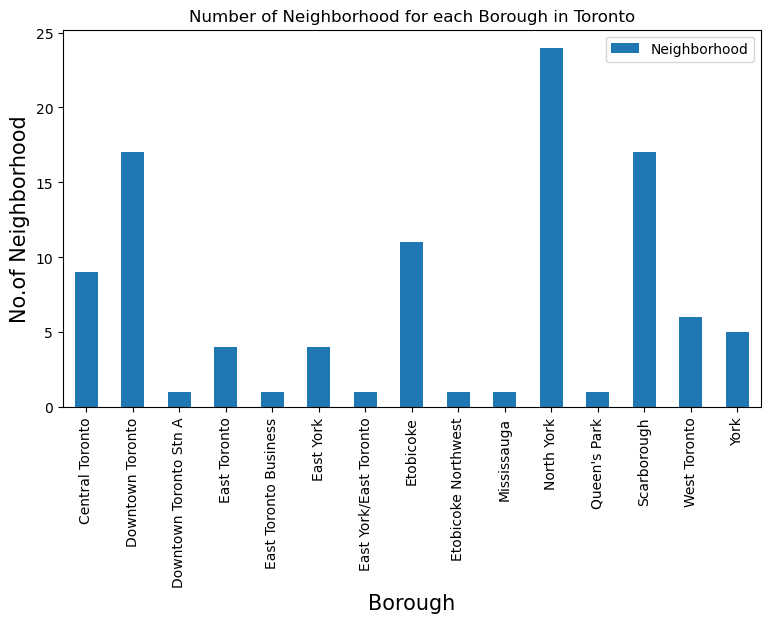

In [10]:
#Plot number of neighborhood for each borough on a bar graph
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_merge.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Use geopy library to get the latitude and longitude values of Toronto

In [11]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lat, lng, borough, neighborhood in zip(
        df_merge['Latitude'], 
        df_merge['Longitude'], 
        df_merge['Borough'], 
        df_merge['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto


### Define Foursquare Credentials and Version

In [13]:
# The code was removed by Watson Studio for sharing.

### Get relevant part of JSON and transform it into a pandas dataframe

In [14]:
#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
#fucntion that extract nearby venvues
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Part 3. Segmenting Neighborhoods in Toronto

### 1. Exploring Scarborough

In [16]:
#create a new dataframe of the Scarborough data.
scarborough_data = df_merge[df_merge['Borough'] == 'Scarborough'].reset_index(drop=True)
scarborough_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,43.727929,-79.262029
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,43.711112,-79.284577
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,43.716316,-79.239476
9,M1N,Scarborough,Birch Cliff / Cliffside West,43.692657,-79.264848


In [17]:
# Get the geographical coordinates of Scarborough.
address = 'Scarborough, Toronto, Ontario'
geolocator = Nominatim(user_agent="scarborough_explorer")
location = geolocator.geocode(address)
scarborough_latitude = location.latitude
scarborough_longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(scarborough_latitude, scarborough_longitude))

The geograpical coordinate of Scarborough are 43.7729744, -79.2576479.


In [18]:
# create map of Scarborough using latitude and longitude values
map_scarborough = folium.Map(location=[scarborough_latitude, scarborough_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(scarborough_data['Latitude'], scarborough_data['Longitude'], scarborough_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scarborough)  
    
map_scarborough

### Create URL and send GET request

In [19]:
#Define limit and radius
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [21]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    scarborough_latitude, 
    scarborough_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json() 

### Clean the json and structure it into a pandas dataframe.

In [22]:
# Clean the json and structure it into a pandas datafram
venues = results['response']['groups'][0]['items']
scarborough_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
scarborough_nearby_venues = scarborough_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
scarborough_nearby_venues['venue.categories'] = scarborough_nearby_venues.apply(get_category_type, axis=1)

# clean columns
scarborough_nearby_venues.columns = [col.split(".")[-1] for col in scarborough_nearby_venues.columns]

scarborough_nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Hot Topic,Clothing Store,43.775450,-79.257929
1,New York Fries - Scarborough TC,Restaurant,43.775135,-79.256858
2,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
3,lululemon athletica,Clothing Store,43.775517,-79.258423
4,Subway,Sandwich Place,43.775102,-79.257115
5,Subway,Sandwich Place,43.771477,-79.252805
6,Disney Store,Toy / Game Store,43.775537,-79.256833
7,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
8,Petro-Canada,Gas Station,43.769724,-79.261677
9,Tim Hortons,Coffee Shop,43.771522,-79.251857


In [23]:
# Number of venvues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(scarborough_nearby_venues.shape[0]))

39 venues were returned by Foursquare.


### Visualize these venuess on the map around our location

In [24]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Scarborough


# add Scarborough as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Scarborough',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(scarborough_nearby_venues.lat, scarborough_nearby_venues.lng, scarborough_nearby_venues.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

### Get Scarborough's nearby venues 

In [25]:
#call function getNearbyVenues
scarborough_venues= getNearbyVenues(names=scarborough_data['Neighborhood'],
                                   latitudes=scarborough_data['Latitude'],
                                   longitudes=scarborough_data['Longitude']
                                  )
scarborough_venues

Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt)
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West
Upper Rouge


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Malvern / Rouge,43.806686,-79.194353,Wendy’s,4bb6b9446edc76b0d771311c,43.807448,-79.199056,Fast Food Restaurant
1,Malvern / Rouge,43.806686,-79.194353,Interprovincial Group,5539e7d2498edaf4b02673ca,43.805630,-79.200378,Print Shop
2,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,Great Shine Window Cleaning,5b19cb3bacc5f5002c693e5c,43.783145,-79.157431,Home Service
3,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,Royal Canadian Legion,4c23d3aaf7ced13a5ed7216d,43.782533,-79.163085,Bar
4,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,5e7116458a090d000896267f,43.782371,-79.156820,Construction & Landscaping
...,...,...,...,...,...,...,...,...
84,Steeles West / L'Amoreaux West,43.799525,-79.318389,Eggsmart,4cd6985967adf04d66d93391,43.796375,-79.318681,Breakfast Spot
85,Steeles West / L'Amoreaux West,43.799525,-79.318389,Fit4Less,578e8b7a498ebcc03535c433,43.798394,-79.318453,Gym
86,Steeles West / L'Amoreaux West,43.799525,-79.318389,Rogers Plus,4ba415b0f964a520c97f38e3,43.798911,-79.318277,Electronics Store
87,Steeles West / L'Amoreaux West,43.799525,-79.318389,Nantha's Bakery,4efccc9bb8f701ff611ce191,43.796430,-79.319151,Indian Restaurant


In [26]:
#Check how many venues were returned for each neighborhood and unique categories can be curated from all the returned venues
scarborough_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Agincourt),4,4,4,4,4,4,4
Birch Cliff / Cliffside West,4,4,4,4,4,4,4
Cedarbrae,9,9,9,9,9,9,9
Clarks Corners / Tam O'Shanter / Sullivan,12,12,12,12,12,12,12
Cliffside / Cliffcrest / Scarborough Village West,2,2,2,2,2,2,2
Dorset Park / Wexford Heights / Scarborough Town Centre,5,5,5,5,5,5,5
Golden Mile / Clairlea / Oakridge,8,8,8,8,8,8,8
Guildwood / Morningside / West Hill,9,9,9,9,9,9,9
Kennedy Park / Ionview / East Birchmount Park,4,4,4,4,4,4,4


In [27]:
#Print out unique categories from the list above
print('There are {} uniques categories.'.format(len(scarborough_venues['Venue Category'].unique())))

There are 56 uniques categories.


### Analyze the Neighborhoods to get the top common venues using one hot coding

In [28]:
# one hot encoding
scarborough_onehot = pd.get_dummies(scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
scarborough_onehot['Neighborhood'] = scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [scarborough_onehot.columns[-1]] + list(scarborough_onehot.columns[:-1])
scarborough_onehot = scarborough_onehot[fixed_columns]

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
scarborough_grouped = scarborough_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 10

# Loop to print each neighborhood along with the top 5 most common venues
for hood in scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = scarborough_grouped[scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt)----
                       venue  freq
0  Latin American Restaurant  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3             Clothing Store  0.25
4        American Restaurant  0.00
5                  Pet Store  0.00
6      Korean BBQ Restaurant  0.00
7             Medical Center  0.00
8              Metro Station  0.00
9         Mexican Restaurant  0.00


----Birch Cliff / Cliffside West----
                       venue  freq
0            College Stadium  0.25
1               Skating Rink  0.25
2      General Entertainment  0.25
3                       Café  0.25
4                  Pet Store  0.00
5  Latin American Restaurant  0.00
6                     Lounge  0.00
7             Medical Center  0.00
8              Metro Station  0.00
9         Mexican Restaurant  0.00


----Cedarbrae----
                  venue  freq
0                Lounge  0.11
1       Thai Restaurant  0.11
2                Bakery  0.11
3                  Bank  0.11
4 

### Let's explore the first neighborhood in our dataframe

In [29]:
scarborough_data.loc[0, 'Neighborhood']

'Malvern / Rouge'

In [30]:
#Get the neighborhood's latitude and longitude values
neighborhood_latitude = scarborough_data.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = scarborough_data.loc[10, 'Longitude'] # neighborhood longitude value

neighborhood_name = scarborough_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern / Rouge are 43.7574096, -79.27330400000001.


In [31]:
#Define the corresponding URL and get request
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json() 

### Get the neighborhood's venues

In [32]:
# Clean the json and structure it into a pandas datafram
venues = results['response']['groups'][0]['items']
malvern_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
malvern_nearby_venues = malvern_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
malvern_nearby_venues['venue.categories'] = malvern_nearby_venues.apply(get_category_type, axis=1)

# clean columns
malvern_nearby_venues.columns = [col.split(".")[-1] for col in malvern_nearby_venues.columns]

malvern_nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Kim Kim restaurant,Chinese Restaurant,43.753833,-79.276611
1,Kairali,Indian Restaurant,43.754915,-79.276945
2,Karaikudi Chettinad South Indian Restaurant,Indian Restaurant,43.756042,-79.276276
3,Pho Vietnam,Vietnamese Restaurant,43.757770,-79.278572
4,Big Al's Pet Supercentre,Pet Store,43.759279,-79.278325


### Get relevant part of JSON and transform it into a pandas dataframe

In [33]:
# Number of venvues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(malvern_nearby_venues.shape[0]))

5 venues were returned by Foursquare.


### Explore Vietnamese restaurants in Scarborough

In [34]:
print('The Vietnamse resraurant within the 500 meter radius of Scarborough: \n')
scarborough_venues.loc[scarborough_venues['Venue Category'] == 'Vietnamese Restaurant']

The Vietnamse resraurant within the 500 meter radius of Scarborough: 



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
49,Dorset Park / Wexford Heights / Scarborough To...,43.75741,-79.273304,Pho Vietnam,4bc75a3c6501c9b630433e29,43.75777,-79.278572,Vietnamese Restaurant


### Get the venue's overall rating from Foursquare API

In [35]:
venue_id = '4bc75a3c6501c9b630433e29' # ID of Pho Vietname
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant rating is  5.9


### 2. Exploring North York

In [36]:
#create a new dataframe of the North York data.
north_york_data = df_merge[df_merge['Borough'] == 'North York'].reset_index(drop=True)
north_york_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.803762,-79.363452
1,M2J,North York,Fairview / Henry Farm / Oriole,43.778517,-79.346556
2,M2K,North York,Bayview Village,43.786947,-79.385975
3,M2L,North York,York Mills / Silver Hills,43.757490,-79.374714
4,M2M,North York,Willowdale / Newtonbrook,43.789053,-79.408493
5,M2N,North York,Willowdale)Sout,43.770120,-79.408493
6,M2P,North York,York Mills West,43.752758,-79.400049
7,M2R,North York,Willowdale)Wes,43.782736,-79.442259
8,M3A,North York,Parkwoods,43.753259,-79.329656
9,M3B,North York,Don Mills)Nort,43.745906,-79.352188


In [37]:
# Get the geographical coordinates of North York.
address = 'North York, Toronto, Ontario'
geolocator = Nominatim(user_agent="North_York_explorer")
location = geolocator.geocode(address)
north_york_latitude = location.latitude
north_york_longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(north_york_latitude, north_york_longitude))

# create map of North York using latitude and longitude values
map_north_york = folium.Map(location=[north_york_latitude, north_york_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(north_york_data['Latitude'], north_york_data['Longitude'], north_york_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_north_york)  
    
map_north_york

The geograpical coordinate of Scarborough are 43.7543263, -79.44911696639593.


### Create URL and send GET request

In [38]:
#define limit and radius
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [39]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    north_york_latitude, 
    north_york_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json() 

### Clean the json and structure it into a pandas dataframe.

In [40]:
# Clean the json and structure it into a pandas datafram
venues = results['response']['groups'][0]['items']
north_york_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
north_york_nearby_venues = north_york_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
north_york_nearby_venues['venue.categories'] = north_york_nearby_venues.apply(get_category_type, axis=1)

# clean columns
north_york_nearby_venues.columns = [col.split(".")[-1] for col in north_york_nearby_venues.columns]

north_york_nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Tim Hortons,Coffee Shop,43.754767,-79.443250
1,Domino's Pizza,Pizza Place,43.753127,-79.450926
2,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507


In [41]:
# Number of venvues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(north_york_nearby_venues.shape[0]))

4 venues were returned by Foursquare.


### Get the borough's nearby venues

In [42]:
#call function getNearbyVenues
north_york_venues= getNearbyVenues(names=north_york_data['Neighborhood'],
                                   latitudes=north_york_data['Latitude'],
                                   longitudes=north_york_data['Longitude']
                                  )
north_york_venues

Hillcrest Village
Fairview / Henry Farm / Oriole
Bayview Village
York Mills / Silver Hills
Willowdale / Newtonbrook
Willowdale)Sout
York Mills West
Willowdale)Wes
Parkwoods
Don Mills)Nort
Don Mills)Sout
Bathurst Manor / Wilson Heights / Downsview North
Northwood Park / York University
Downsview)East 
Downsview)Wes
Downsview)Centra
Downsview)Northwes
Victoria Village
Bedford Park / Lawrence Manor East
Lawrence Manor / Lawrence Heights
Glencairn
North Park / Maple Leaf Park / Upwood Park
Humber Summit
Humberlea / Emery


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Hillcrest Village,43.803762,-79.363452,New York Fries,4d8771f6651041bd5e499b30,43.803664,-79.363905,Fast Food Restaurant
1,Hillcrest Village,43.803762,-79.363452,Eagle's Nest Golf Club,4ad9dce6f964a520651b21e3,43.805455,-79.364186,Golf Course
2,Hillcrest Village,43.803762,-79.363452,AY Jackson Pool,4e1fad69fa761d67106a9989,43.804515,-79.366138,Pool
3,Hillcrest Village,43.803762,-79.363452,Villa Madina,5331a799498e3bfbae4a5a04,43.801685,-79.363938,Mediterranean Restaurant
4,Hillcrest Village,43.803762,-79.363452,Duncan Creek Park,4c64ca1b772bef3bfadbc2aa,43.805539,-79.360695,Dog Run
...,...,...,...,...,...,...,...,...
239,North Park / Maple Leaf Park / Upwood Park,43.713756,-79.490074,Queen's GreenBelt Park,4f8ba717121d29fd94277ce8,43.712355,-79.484754,Trail
240,North Park / Maple Leaf Park / Upwood Park,43.713756,-79.490074,Mika's Trim,590bdb6bbe70781ade1dab8a,43.714068,-79.496113,Construction & Landscaping
241,Humber Summit,43.756303,-79.565963,HNS ARARAT,54fb21be498e513a0a853128,43.757519,-79.563653,Furniture / Home Store
242,Humber Summit,43.756303,-79.565963,Paul Davis Canada of York Region,57b20e5e498e2f95667c4fd6,43.755852,-79.560256,Home Service


In [43]:
#Check how many venues were returned for each neighborhood 
north_york_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Bathurst Manor / Wilson Heights / Downsview North,22,22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,26,26,26,26,26,26,26
Don Mills)Nort,4,4,4,4,4,4,4
Don Mills)Sout,20,20,20,20,20,20,20
Downsview)Centra,3,3,3,3,3,3,3
Downsview)East,2,2,2,2,2,2,2
Downsview)Northwes,4,4,4,4,4,4,4
Downsview)Wes,5,5,5,5,5,5,5


In [44]:
#Print out the unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(north_york_venues['Venue Category'].unique())))

There are 101 uniques categories.


### Analyze the Neighborhoods to get the top common venues using one hot coding

In [45]:
# one hot encoding
north_york_onehot = pd.get_dummies(north_york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
north_york_onehot['Neighborhood'] = north_york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [north_york_onehot.columns[-1]] + list(north_york_onehot.columns[:-1])
north_york_onehot = north_york_onehot[fixed_columns]

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
north_york_grouped = north_york_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 10

# Loop to print each neighborhood along with the top 5 most common venues
for hood in north_york_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = north_york_grouped[north_york_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor / Wilson Heights / Downsview North----
                       venue  freq
0                       Bank  0.09
1                Coffee Shop  0.09
2  Middle Eastern Restaurant  0.05
3                Supermarket  0.05
4                Pizza Place  0.05
5                   Pharmacy  0.05
6                 Restaurant  0.05
7                      Diner  0.05
8             Sandwich Place  0.05
9              Deli / Bodega  0.05


----Bayview Village----
                       venue  freq
0         Chinese Restaurant  0.25
1                       Café  0.25
2                       Bank  0.25
3        Japanese Restaurant  0.25
4          Accessories Store  0.00
5               Liquor Store  0.00
6              Movie Theater  0.00
7          Mobile Phone Shop  0.00
8         Miscellaneous Shop  0.00
9  Middle Eastern Restaurant  0.00


----Bedford Park / Lawrence Manor East----
                     venue  freq
0           Sandwich Place  0.08
1              Coffee Shop  0.08
2 

### Let's explore the second neighborhood in North York

In [46]:
north_york_data.loc[1, 'Neighborhood']
#get the second neighborhood latitude an longtude
fairview_henryfarm_oriole_neighborhood_latitude = north_york_data.loc[1, 'Latitude'] # neighborhood latitude value
fairview_henryfarm_oriole_neighborhood_longitude = north_york_data.loc[1, 'Longitude'] # neighborhood longitude value

fairview_henryfarm_oriole_neighborhood_name = north_york_data.loc[1, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(fairview_henryfarm_oriole_neighborhood_name, 
                                                               fairview_henryfarm_oriole_neighborhood_latitude, 
                                                               fairview_henryfarm_oriole_neighborhood_longitude))

Latitude and longitude values of Fairview / Henry Farm / Oriole are 43.7785175, -79.3465557.


In [47]:
north_york_data.loc[1, 'Neighborhood']

'Fairview / Henry Farm / Oriole'

### Create URL and send GET request

In [48]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# Define the corresponding URL and get request
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    fairview_henryfarm_oriole_neighborhood_latitude, 
    fairview_henryfarm_oriole_neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json() 

In [49]:
# Clean the json and structure it into a pandas datafram
venues = results['response']['groups'][0]['items']
fairview_henryfarm_oriole_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
fairview_henryfarm_oriole_nearby_venues = fairview_henryfarm_oriole_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
fairview_henryfarm_oriole_nearby_venues['venue.categories'] = fairview_henryfarm_oriole_nearby_venues.apply(get_category_type, axis=1)

# clean columns
fairview_henryfarm_oriole_nearby_venues.columns = [col.split(".")[-1] for col in fairview_henryfarm_oriole_nearby_venues.columns]

fairview_henryfarm_oriole_nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,De Berardini's,Salon / Barbershop,43.778069,-79.342642
1,Moxie's Classic Grill,American Restaurant,43.777779,-79.343185
2,RBC Royal Bank,Bank,43.777304,-79.344653
3,TD Canada Trust,Bank,43.777763,-79.345974
4,New York Fries - Fairview Mall,Restaurant,43.778605,-79.343577
...,...,...,...,...
62,Don Mills Subway Station Passenger Pickup,Bus Station,43.775796,-79.345007
63,Fit For Life,Fast Food Restaurant,43.779352,-79.350568
64,Circle K,Convenience Store,43.775442,-79.347839
65,Don Mills & Sheppard,Intersection,43.775323,-79.346998


In [50]:
# Number of venvues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(fairview_henryfarm_oriole_nearby_venues.shape[0]))

67 venues were returned by Foursquare.


### Explore Vietnamese restaurants in North York

In [51]:
print('The Vietnamse resraurant within the 500 meter radius of North York: \n')
north_york_venues.loc[north_york_venues['Venue Category'] == 'Vietnamese Restaurant']

The Vietnamse resraurant within the 500 meter radius of North York: 



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
97,Willowdale)Sout,43.770120,-79.408493,Pho 88 Vietnamese Cuisine,4b4779f0f964a520543326e3,43.770456,-79.413064,Vietnamese Restaurant
173,Northwood Park / York University,43.767980,-79.487262,Phở Liên Hương,51030632e4b0840c0152c004,43.764437,-79.489775,Vietnamese Restaurant
222,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,Lac Vien Vietnamese Restaurant,4ccc5aebee23a14370591ea8,43.721259,-79.468472,Vietnamese Restaurant


### Get the restaurants' overall rating

In [52]:
venue_id = '4b4779f0f964a520543326e3' # ID of Pho 88 Vietname
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant rating is  6.1


In [53]:
venue_id = '4ccc5aebee23a14370591ea8' # ID of Lac Vien Restaurant
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant rating is  7.6


In [54]:
venue_id = '51030632e4b0840c0152c004' # ID of Pho Lien Huong
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant has not been rated yet.


### 2. Exploring Downtown Toronto

In [55]:
#create a new dataframe of the Scarborough data.
downtown_toronto_data = df_merge[df_merge['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_toronto_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,St. James Town / Cabbagetown,43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,M5H,Downtown Toronto,Richmond / Adelaide / King,43.650571,-79.384568
9,M5J,Downtown Toronto,Harbourfront East / Union Station / Toronto Is...,43.640816,-79.381752


In [56]:
# Get the geographical coordinates of Downtown Toronto.
address = 'Downtown Toronto, Toronto, Ontario'
geolocator = Nominatim(user_agent="downtown_toronto_explorer")
location = geolocator.geocode(address)
downtown_toronto_latitude = location.latitude
downtown_toronto_longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(downtown_toronto_latitude, downtown_toronto_longitude))

# create map of Downtown Toronto using latitude and longitude values
map_downtown_toronto= folium.Map(location=[downtown_toronto_latitude, downtown_toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(downtown_toronto_data['Latitude'], downtown_toronto_data['Longitude'], downtown_toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown_toronto)  
    
map_downtown_toronto

The geograpical coordinate of Scarborough are 43.6563221, -79.3809161.


In [57]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# Send GET request for result
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    downtown_toronto_latitude, 
    downtown_toronto_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json() 

In [58]:
# Clean the json and structure it into a pandas datafram
venues = results['response']['groups'][0]['items']
downtown_toronto_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
downtown_toronto_nearby_venues = downtown_toronto_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
downtown_toronto_nearby_venues['venue.categories'] = downtown_toronto_nearby_venues.apply(get_category_type, axis=1)

# clean columns
downtown_toronto_nearby_venues.columns = [col.split(".")[-1] for col in downtown_toronto_nearby_venues.columns]

downtown_toronto_nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Blaze Pizza,Pizza Place,43.656518,-79.380015
1,Silver Snail Comics,Comic Shop,43.657031,-79.381403
2,Burrito Boyz,Burrito Place,43.656265,-79.378343
3,The Elm Tree Restaurant,Modern European Restaurant,43.657397,-79.383761
4,UNIQLO ユニクロ,Clothing Store,43.655910,-79.380641
...,...,...,...,...
91,Sol'exotica Tanning Spa,Tanning Salon,43.654562,-79.376663
92,Starbucks,Coffee Shop,43.654841,-79.375815
93,Somethin' 2 Talk About,Middle Eastern Restaurant,43.658395,-79.385338
94,Booster Juice,Smoothie Shop,43.652658,-79.378459


In [59]:
# Number of venvues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(downtown_toronto_nearby_venues.shape[0]))

96 venues were returned by Foursquare.


In [60]:
downtown_toronto_venues= getNearbyVenues(names=downtown_toronto_data['Neighborhood'],
                                   latitudes=downtown_toronto_data['Latitude'],
                                   longitudes=downtown_toronto_data['Longitude']
                                  )
downtown_toronto_venues

Rosedale
St. James Town / Cabbagetown
Church and Wellesley
Regent Park / Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond / Adelaide / King
Harbourfront East / Union Station / Toronto Islands
Toronto Dominion Centre / Design Exchange
Commerce Court / Victoria Hotel
University of Toronto / Harbord
Kensington Market / Chinatown / Grange Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport
First Canadian Place / Underground city
Christie


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,4aff2d47f964a520743522e3,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,4bd777aa5cf276b054639b00,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,4d0e77df76cc37045715767c,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,4ef8f2a3775b54cdb5bdec7c,43.676352,-79.373842,Trail
4,St. James Town / Cabbagetown,43.667967,-79.367675,Cabbagetown Brew,5093f826e4b08bdedeedcc16,43.666923,-79.369289,Café
...,...,...,...,...,...,...,...,...
1096,Christie,43.669542,-79.422564,Dupont Disco,4d72ca285838a09358d410db,43.670490,-79.426611,Nightclub
1097,Christie,43.669542,-79.422564,Queens Club,4bfc2a7fe05e0f47b348cfa8,43.672386,-79.418106,Athletics & Sports
1098,Christie,43.669542,-79.422564,Marian Engel Park,4c840c82d8086dcbcfcb8552,43.673754,-79.423988,Park
1099,Christie,43.669542,-79.422564,Garrison Creek Park,4d8fe809cb9b224bd1c3a541,43.671690,-79.427805,Park


In [61]:
#Check how many venues were returned for each neighborhood 
downtown_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Berczy Park,58,58,58,58,58,58,58
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport,17,17,17,17,17,17,17
Central Bay Street,65,65,65,65,65,65,65
Christie,16,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79,79
Commerce Court / Victoria Hotel,100,100,100,100,100,100,100
First Canadian Place / Underground city,100,100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100,100
Harbourfront East / Union Station / Toronto Islands,100,100,100,100,100,100,100


In [62]:
#Print out the unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(downtown_toronto_venues['Venue Category'].unique())))

There are 202 uniques categories.


In [63]:
# one hot encoding
downtown_toronto_onehot = pd.get_dummies(downtown_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_toronto_onehot['Neighborhood'] = downtown_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_toronto_onehot.columns[-1]] + list(downtown_toronto_onehot.columns[:-1])
downtown_toronto_onehot = downtown_toronto_onehot[fixed_columns]

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
downtown_toronto_grouped = downtown_toronto_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 10

# Loop to print each neighborhood along with the top 5 most common venues
for hood in downtown_toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = downtown_toronto_grouped[downtown_toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.10
1        Cocktail Bar  0.05
2              Bakery  0.05
3  Seafood Restaurant  0.03
4         Cheese Shop  0.03
5          Restaurant  0.03
6            Beer Bar  0.03
7      Farmers Market  0.03
8               Diner  0.02
9                Café  0.02


----CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport----
                 venue  freq
0      Airport Service  0.18
1       Airport Lounge  0.12
2     Airport Terminal  0.12
3      Harbor / Marina  0.06
4                Plane  0.06
5        Boat or Ferry  0.06
6     Sculpture Garden  0.06
7                  Bar  0.06
8  Rental Car Location  0.06
9             Boutique  0.06


----Central Bay Street----
                    venue  freq
0             Coffee Shop  0.17
1          Sandwich Place  0.06
2                    Café  0.05
3      Italian Restaurant  0.05
4         Bubble Tea Shop  0.03
5     Jap

In [64]:
print('The Vietnamse resraurant within the 500 meter radius of North York: \n')
downtown_toronto_venues.loc[downtown_toronto_venues['Venue Category'] == 'Vietnamese Restaurant']

The Vietnamse resraurant within the 500 meter radius of North York: 



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
219,"Garden District, Ryerson",43.657162,-79.378937,Fine Asian Bowl,4aea2b14f964a520ebb921e3,43.655387,-79.380326,Vietnamese Restaurant
905,Kensington Market / Chinatown / Grange Park,43.653206,-79.400049,Banh Mi Nguyen Huong,4af45a8af964a52097f121e3,43.653628,-79.398376,Vietnamese Restaurant
960,Kensington Market / Chinatown / Grange Park,43.653206,-79.400049,Saigon Lotus Restaurant,58a7c100076be13f60d1dff5,43.654311,-79.399225,Vietnamese Restaurant
961,Kensington Market / Chinatown / Grange Park,43.653206,-79.400049,Pho Tien,50e6282de4b026ac78e0ee70,43.652832,-79.406242,Vietnamese Restaurant


In [65]:
venue_id = '4aea2b14f964a520ebb921e3' # ID of Fine Asian Bowl
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant rating is  6.8


In [66]:
venue_id = '4af45a8af964a52097f121e3' # ID of Banh Mi Nguyen Huong
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant rating is  8.9


In [67]:
venue_id = '58a7c100076be13f60d1dff5' # ID of Saigon Lotus
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant has not been rated yet.


In [68]:
venue_id = '50e6282de4b026ac78e0ee70' # ID of Pho Tien
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result['response']['venue']
try:
    print('This restaurant rating is ', result['response']['venue']['rating'])
except:
    print('This restaurant has not been rated yet.')

This restaurant rating is  6.1
